In [220]:
# Libraries

# Agent-based modeling
import mesa

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Data manipulation
import numpy as np
import pandas as pd

In [221]:
## metrics used

# gini index
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B

# amount of discrimination?

# utility function

# company

# (A) sensitive attribute
# individuals from group A1
# infividiuals from group A2

# cost function

# company's cost increase as they provide service to more areas
# areas where A1 live have a higher earning, which is why company discriminates

# our goal is to see if this helps the company and the economy in the long run 
# how does the service provided by the company affect the economy?

# Fair Scenario

# Discrimination Scenario

In [222]:
# Set the coordinates of discriminated neighborhoods
discriminated_neighborhoods = [(0, 0), (3, 3)]

In [223]:
class MoneyAgent(mesa.Agent):
    def __init__(self, unique_id, model, initial_neighborhood):
        super().__init__(unique_id, model)
        self.wealth = 1
        self.life_quality = 1  # Initialize life quality
        self.initial_neighborhood = initial_neighborhood  # Track initial neighborhood

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def make_money(self, amount):
        if self.life_quality > 0:
            self.wealth += amount * (1 + self.life_quality)
        else:
            self.wealth += amount  # No life quality increase

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        cellmates.pop(cellmates.index(self))  # Ensure agent is not giving money to itself
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 0.5
            self.wealth -= 0.5

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()
        self.wealth *= self.life_quality  # Update wealth based on life quality

life_qual_multiplier = 0.01 # parameter that sets how much the life quality of an agent increase if provided service

class ServiceCompany:
    def __init__(self, model, discriminated_neighborhoods):
        self.model = model
        self.discriminated_neighborhoods = discriminated_neighborhoods
        self.profit = []  # Initialize profit list
        self.cost = []  # Initialize cost list

    def provide_service(self):
        width, height = self.model.grid.width, self.model.grid.height
        profit = 0  # Initialize profit for this step
        cost = 0  # Initialize cost for this step
        for x in range(width):
            for y in range(height):
                for content in self.model.grid.get_cell_list_contents((x, y)):
                    agent = content
                    if agent.initial_neighborhood == "Non-Discriminated":
                        # Provide service to agents whose initial neighborhood is discriminated
                        agent.life_quality += life_qual_multiplier
                        profit += 1  # Increase company's profit for this step
                        cost += 0.1  # Increase company's cost for providing service for this step
        # Append profit and cost for this step to their respective lists
        self.profit.append(profit)
        self.cost.append(cost)

    def calculate_total_profit(self):
        # Calculate total profit by summing up profit over all steps and subtracting total cost
        total_revenue = sum(self.profit)  # Each service provided contributes to revenue by 1 unit
        total_cost = sum(self.cost)
        total_profit = total_revenue - total_cost
        return total_profit

In [224]:
class MoneyModelWithCompany(mesa.Model):
    def __init__(self, N, width, height, discriminated_neighborhoods):
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)
        self.company = ServiceCompany(self, discriminated_neighborhoods)

        # Create agents
        for i in range(self.num_agents):
            initial_neighborhood = self.random.choice(["Discriminated", "Non-Discriminated"])
            a = MoneyAgent(i, self, initial_neighborhood)  # Pass initial neighborhood
            self.schedule.add(a)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth", "InitialNeighborhood": "initial_neighborhood"}
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        self.company.provide_service()

In [225]:
# Set the coordinates of discriminated neighborhoods
discriminated_neighborhoods = [(0, 0), (3, 3)]

In [226]:
# Run the simulation
model = MoneyModelWithCompany(100, 10, 10, discriminated_neighborhoods)
for i in range(100):
    model.step()  # Step the model
    # Provide service after stepping the model
    model.company.provide_service()  

/var/folders/2p/zsvmljhd45n72ws61v37xglh0000gn/T/ipykernel_61923/1855785754.py:3: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


In [227]:
# Calculate the profit of the company
total_profit = model.company.calculate_total_profit()
print("Total Profit:", total_profit)

Total Profit: 10079.999999999998


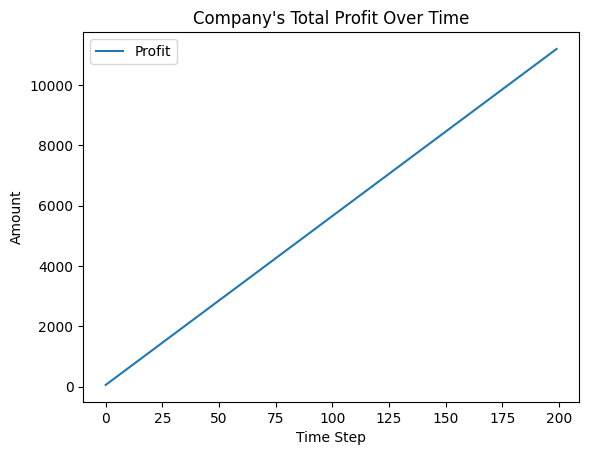

In [228]:
# Plot the company's profit over time
accumulated_profit = np.cumsum(model.company.profit)
plt.plot(range(200), accumulated_profit, label="Profit")
#plt.plot(range(200), model.company.cost, label="Cost")
plt.xlabel("Time Step")
plt.ylabel("Amount")
plt.title("Company's Total Profit Over Time")
plt.legend()
plt.show()

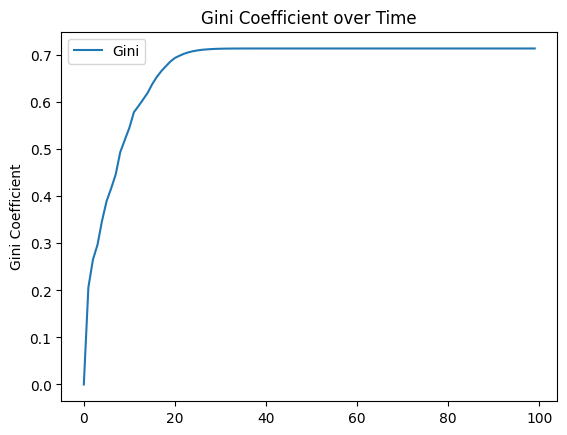

In [229]:
# Calculate the target metrics
gini = model.datacollector.get_model_vars_dataframe()

# Plot the Gini coefficient over time
g = sns.lineplot(data=gini)
g.set(title="Gini Coefficient over Time", ylabel="Gini Coefficient");

In [230]:
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.head()

Wealth InitialNeighborhood
Step AgentID                            
0    0           1.0   Non-Discriminated
     1           1.0   Non-Discriminated
     2           1.0   Non-Discriminated
     3           1.0       Discriminated
     4           1.0   Non-Discriminated

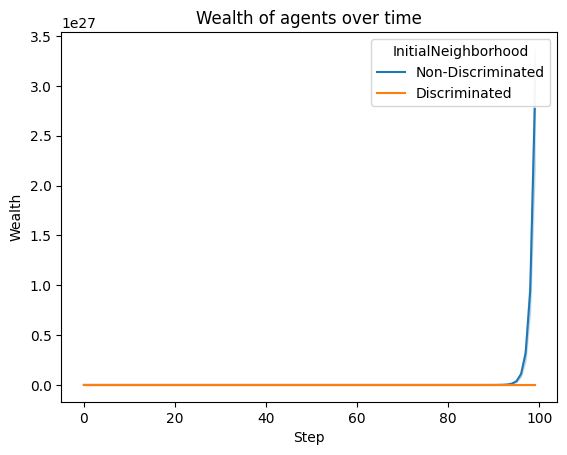

In [231]:
# 1. Collect Agent Wealth Data with Neighborhood Information
agent_wealth = model.datacollector.get_agent_vars_dataframe()

# 2. Plot the Wealth of Agents Over Time

# Plot the wealth of agents from discriminated neighborhoods over time
sns.lineplot(data=agent_wealth, x="Step", y="Wealth", hue="InitialNeighborhood")
plt.title("Wealth of agents over time")
plt.xlabel("Step")
plt.ylabel("Wealth")
plt.show()

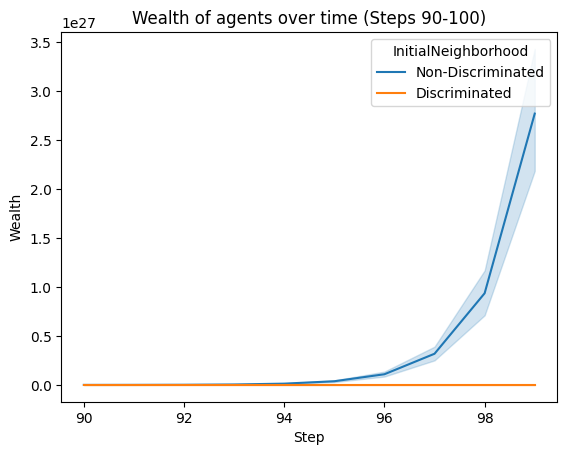

In [232]:
# Filter the data to include only steps 90-100
agent_wealth_zoomed = agent_wealth.loc[(90 <= agent_wealth.index.get_level_values('Step')) & (agent_wealth.index.get_level_values('Step') <= 100)]

# Plot the wealth of agents from discriminated neighborhoods over time (zoomed in)
sns.lineplot(data=agent_wealth_zoomed, x="Step", y="Wealth", hue="InitialNeighborhood")
plt.title("Wealth of agents over time (Steps 90-100)")
plt.xlabel("Step")
plt.ylabel("Wealth")
plt.show()

# Simulation with Policy Intervention after Step k

In [264]:
k = 5 # Step at which the policy intervention occurs

class MoneyModelWithCompany(mesa.Model):
    def __init__(self, N, width, height, discriminated_neighborhoods):
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)
        self.company = ServiceCompany(self, discriminated_neighborhoods)

        # Create agents
        for i in range(self.num_agents):
            initial_neighborhood = self.random.choice(["Discriminated", "Non-Discriminated"])
            a = MoneyAgent(i, self, initial_neighborhood)  # Pass initial neighborhood
            self.schedule.add(a)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth", "InitialNeighborhood": "initial_neighborhood"}
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        self.company.provide_service()

class ServiceCompany:
    def __init__(self, model, discriminated_neighborhoods):
        self.model = model
        self.discriminated_neighborhoods = discriminated_neighborhoods
        self.profit = []  # Initialize profit list
        self.cost = []  # Initialize cost list

    def provide_service(self):
        width, height = self.model.grid.width, self.model.grid.height
        profit = 0  # Initialize profit for this step
        cost = 0  # Initialize cost for this step
        # Check the current step number
        current_step = self.model.schedule.steps
        for x in range(width):
            for y in range(height):
                for content in self.model.grid.get_cell_list_contents((x, y)):
                    agent = content
                    # Serve non-discriminated neighborhoods before step n, and everyone after step n
                    if current_step > k or agent.initial_neighborhood != "Discriminated":
                        agent.life_quality += life_qual_multiplier
                        profit += 1  # Increase company's profit for this step
                        cost += 0.1  # Increase company's cost for providing service for this step
        # Append profit and cost for this step to their respective lists
        self.profit.append(profit)
        self.cost.append(cost)

    def calculate_total_profit(self):
        # Calculate total profit by summing up profit over all steps and subtracting total cost
        total_revenue = sum(self.profit)  # Each service provided contributes to revenue by 1 unit
        total_cost = sum(self.cost)
        total_profit = total_revenue - total_cost
        return total_profit



# Run the simulation
model = MoneyModelWithCompany(100, 10, 10, discriminated_neighborhoods)
for i in range(100):  # Run for 200 steps to allow for the policy intervention
    model.step()

# Further analysis or visualization


/var/folders/2p/zsvmljhd45n72ws61v37xglh0000gn/T/ipykernel_61923/1855785754.py:3: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


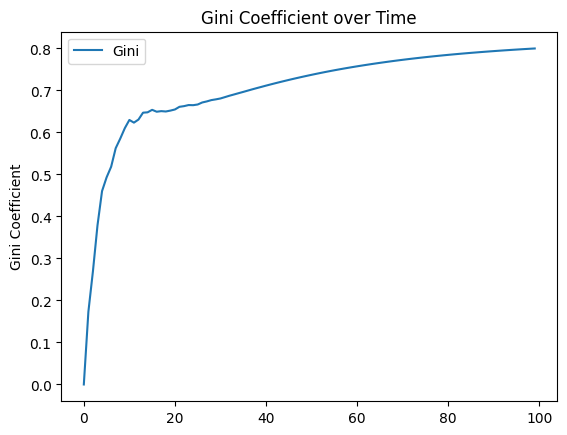

In [265]:
# Calculate the target metrics
gini = model.datacollector.get_model_vars_dataframe()

# Plot the Gini coefficient over time
g = sns.lineplot(data=gini)
g.set(title="Gini Coefficient over Time", ylabel="Gini Coefficient");

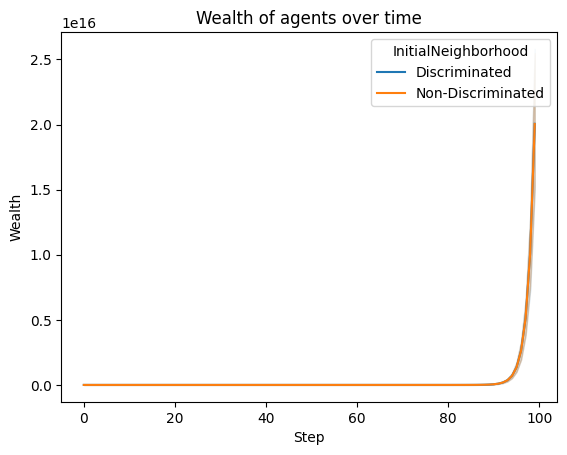

In [261]:
# 1. Collect Agent Wealth Data with Neighborhood Information
agent_wealth = model.datacollector.get_agent_vars_dataframe()

# 2. Plot the Wealth of Agents Over Time

# Plot the wealth of agents from discriminated neighborhoods over time
sns.lineplot(data=agent_wealth, x="Step", y="Wealth", hue="InitialNeighborhood")
plt.title("Wealth of agents over time")
plt.xlabel("Step")
plt.ylabel("Wealth")
plt.show()

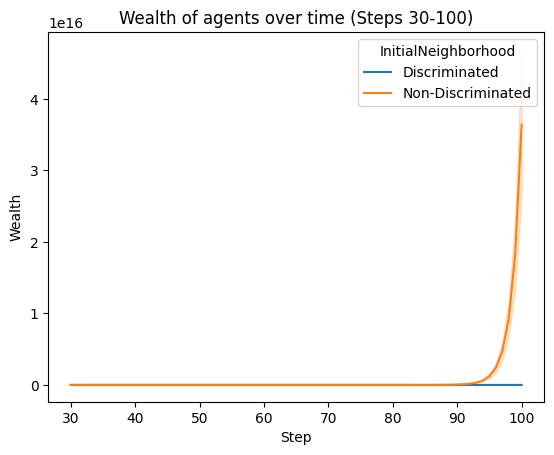

In [252]:
# Filter the data to include only steps 30-100
agent_wealth_zoomed = agent_wealth.loc[(30 <= agent_wealth.index.get_level_values('Step')) & (agent_wealth.index.get_level_values('Step') <= 100)]

# Plot the wealth of agents from discriminated neighborhoods over time (zoomed in)
sns.lineplot(data=agent_wealth_zoomed, x="Step", y="Wealth", hue="InitialNeighborhood")
plt.title("Wealth of agents over time (Steps 30-100)")
plt.xlabel("Step")
plt.ylabel("Wealth")
plt.show()